In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [2]:
# Inlezen van CSV-bestand
dataPositions = pd.read_csv('../interpolated-data/positions_xyz_128px_full.csv')
dataCoordinates = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_full.csv')
dataPositions.shape, dataCoordinates.shape

((4711, 3), (4711, 14))

In [3]:
combined = pd.concat([dataCoordinates, dataPositions], axis=1)
# remove the rows with to more than 3 NaN values

combined = combined.dropna(thresh=combined.shape[1]-3)
combined

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.0,42.0,87.0,39.0,34.853473,82.531266,44.000000,83.00000,89.000000,83.000000,28.886553,118.791444,69.000000,122.000000,10.138330,3.169981,15.09998
1,0.5,42.5,87.0,40.0,34.853473,82.531266,45.000000,84.00000,89.000000,84.000000,28.886553,118.791444,68.500000,120.500000,10.133340,3.269852,15.19985
2,0.5,43.5,87.0,41.0,34.853473,82.531266,45.000000,85.00000,89.000000,85.000000,28.886553,118.791444,68.500000,120.500000,10.125010,3.369500,15.29950
3,1.0,45.0,87.5,42.0,34.853473,82.531266,45.000000,86.00000,89.000000,86.000000,28.886553,118.791444,68.500000,120.500000,10.113370,3.468816,15.39882
4,1.0,45.5,88.0,43.0,34.853473,82.531266,45.000000,86.00000,90.000000,87.000000,28.886553,118.791444,68.500000,120.500000,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,122.0,64.0,79.0,115.0,121.000000,117.000000,45.465763,106.74694,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.720146,3.151380,7.95000
4707,123.0,62.0,96.0,120.5,121.000000,115.000000,45.465763,106.74694,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.714249,3.084737,7.95000
4708,123.0,61.0,96.0,120.5,121.000000,113.000000,45.465763,106.74694,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.708378,3.018077,7.95000
4709,123.0,57.0,79.0,115.0,121.000000,109.000000,45.465763,106.74694,84.286003,95.550908,-29.617042,237.188872,90.315662,134.650737,4.702536,2.951475,7.95000


In [4]:
X = combined.iloc[:, :14] # select all rows and columns from 0 to 13
y = combined.iloc[:, 14:] # select x y z output columns

### Data Preprocessing

In [5]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)
dfX = imputer.fit_transform(X)
y = imputer.fit_transform(y)

### Splitting the dataset into the Training set and Test set

In [6]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dfX, y, test_size=0.2, random_state=42)

# Splitting the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [7]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

X_train_scaled.shape[0], X_val_scaled.shape[0], X_test_scaled.shape[0]

(2826, 942, 943)

### Hyperparameter tuning

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor

# Define a parameter grid for the MLPRegressor
param_grid = {
    'model__hidden_layer_sizes': [(200,), (500,)],
    'model__activation': ['identity', 'logistic', 'tanh', 'relu'],
    'model__solver': ['sgd', 'adam'],
    'model__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'model__learning_rate_init': [0.001, 0.01, 0.1],
    'model__max_iter': [10000, 20000, 28000],
    'model__early_stopping': [True],
}

# Create a pipeline with an MLPRegressor model
pipeline = Pipeline([
    ('model', MLPRegressor(random_state=42))
])

# Perform a randomized search over the parameter grid
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

#### Train the model

In [9]:
random_search.fit(X_train_scaled, y_train_scaled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('model',
                                              MLPRegressor(random_state=42))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__activation': ['identity',
                                                              'logistic',
                                                              'tanh', 'relu'],
                                        'model__early_stopping': [True],
                                        'model__hidden_layer_sizes': [(100,),
                                                                      (150,),
                                                                      (200,)],
                                        'model__learning_rate': ['constant',
                                                                 'invscaling',
                                                                 'adaptive'],
                                        'model__learning_rate_init': [0.001,
                                                                      0.01,
                                                                      0.1],
                                        'model__max_iter': [10000, 20000,
                                                            28000],
                                        'model__solver': ['sgd', 'adam']},
                   random_state=42, verbose=2)

#### Result of the hyperparameter tuning

In [10]:
model = random_search.best_estimator_

In [11]:
print('fBest parameters found:\n', random_search.best_params_)

fBest parameters found:
 {'model__solver': 'sgd', 'model__max_iter': 20000, 'model__learning_rate_init': 0.1, 'model__learning_rate': 'adaptive', 'model__hidden_layer_sizes': (200,), 'model__early_stopping': True, 'model__activation': 'relu'}


#### Make Predictions

In [12]:
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

#### Evaluate the model

In [13]:
from utils.evaluate import evaluate_model

mse_val, mae_val, r2_val = evaluate_model(y_val, y_val_pred, "Validation")

Mean Squared Error on Validation Set: 0.033639182338168906
Mean Absolute Error on Validation Set: 0.09429313029478226
R2 Score on Validation set: 0.9961431220111491


In [14]:
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

In [15]:
mse_test, mae_test, r2_test = evaluate_model(y_test, y_test_pred, "Test")

Mean Squared Error on Test Set: 0.03419581327560361
Mean Absolute Error on Test Set: 0.09740113005820468
R2 Score on Test set: 0.9961288488449517


#### Visualize the results
The test data is randomized so the plot won't show a clean trajectory

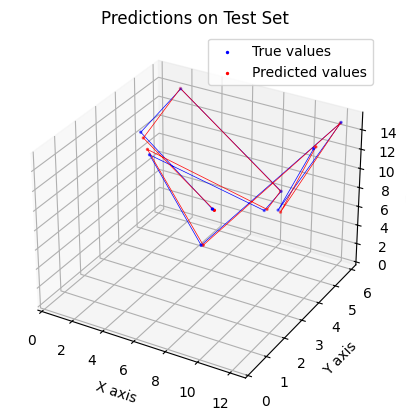

In [16]:
from utils.plot_maker_gaussian_process import plot_maker_3d

plot_maker_3d(np.array(y_test)[:10], np.array(y_test_pred)[:10], "Predictions on Test Set")

# Make Predictions on new data

In [17]:
test_data = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_13h38m.csv', delimiter=',', decimal='.')
test_result = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_13h38m.csv', delimiter=',', decimal='.')

In [18]:
new_combined = pd.concat([test_data, test_result], axis=1)
new_combined = new_combined.dropna(thresh=new_combined.shape[1]-3)
new_combined = new_combined

In [19]:
new_X = new_combined.iloc[:, :14]
new_y = new_combined.iloc[:, 14:]
new_X.shape, new_y.shape

((1474, 14), (1474, 3))

In [20]:
new_X_imputed = imputer.fit_transform(new_X)

new_X_scaled = scaler_X.fit_transform(new_X_imputed)
new_y_scaled = scaler_y.fit_transform(new_y)

In [21]:
new_y_pred_scaled = model.predict(new_X_scaled)

In [22]:
new_y_pred = scaler_y.inverse_transform(new_y_pred_scaled)

In [23]:
new_mse, new_mae, new_r2 = evaluate_model(new_y, new_y_pred, "New Data")

Mean Squared Error on New Data Set: 0.38720901786196826
Mean Absolute Error on New Data Set: 0.46283385762474333
R2 Score on New Data set: 0.6072601914804047


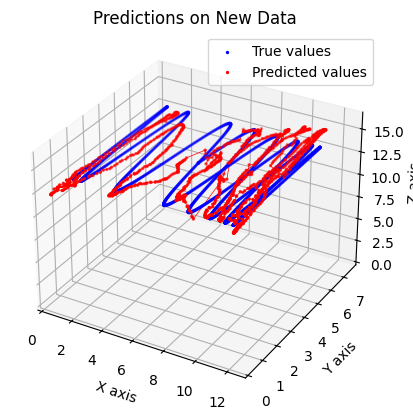

In [25]:
plot_maker_3d(np.array(new_y), np.array(new_y_pred), "Predictions on New Data")